<a href="https://colab.research.google.com/github/hanatran77/similarity-glowing-parakeet/blob/main/PubMedBERT_similarity_score.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from transformers import AutoTokenizer, AutoModel
import torch
from torch.nn.functional import cosine_similarity

In [ ]:
# Load PubMedBERT
model_name = "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)
model.eval()

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/385 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSdpaSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False

In [ ]:
# Embedder function
def get_embedding(text):
    inputs = tokenizer(text, return_tensors= "pt", truncation=True, padding=True,max_length=256)
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.last_hidden_state.mean(dim=1)  # Mean pooling

In [ ]:
# Your query
candidate_genes = pd.read_csv("/content/filter_rank_DEGs.csv", delimiter= ",")
# Get query embedding
query_text = "Show me the semantic similarity score between the different genes from the input list"
query_vec = get_embedding(query_text)
candidate_genes

,Gene Symbol,Regulation,Description,T2D_Similarity_Score,MT_Dysfunction_Similarity_Score
0,MTFR2,down,mitochondrial fission regulator 2,0.881408,0.919369
1,MATR3,down,matrin 3,0.874628,0.918613
2,YARS,down,tyrosyl-tRNA synthetase,0.879315,0.918282
3,MCM10,down,minichromosome maintenance 10 replication init...,0.873346,0.918277
4,VAPA,up,VAMP associated protein A,0.875424,0.917658
...,...,...,...,...,...
307,PHOSPHO2,down,"phosphatase, orphan 2",0.864838,0.903926
308,VWA8,down,von Willebrand factor A domain containing 8,0.864239,0.903747
309,PGAM2,down,phosphoglycerate mutase 2 (muscle),0.871366,0.903567
310,INTU,down,inturned planar cell polarity protein,0.866861,0.903326


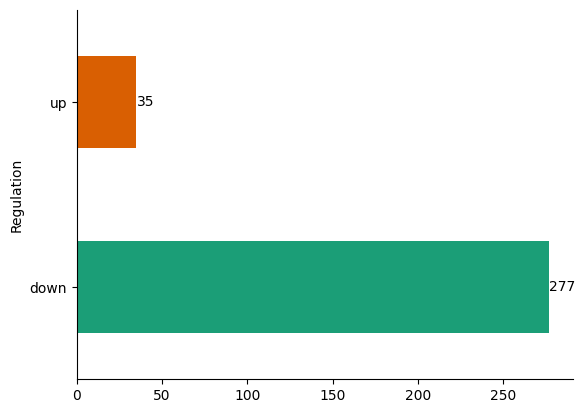

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns
# Create the plot
ax = candidate_genes.groupby('Regulation').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

# Add labels to the bars
for container in ax.containers:
    ax.bar_label(container, label_type='edge')

plt.show()

In [ ]:
# Compute similarity
results = []

for _, row in candidate_genes.iterrows():
    gene = row['Gene Symbol']
    regulation = row['Regulation']
    func = row['Description']
    # Create query
    prompt = f"Given gene {gene}, with {regulation} regulation, has the function of {func}"
    query_vec = get_embedding(prompt)

    # Score all candidates
    matches = []
    for _, cand_row in candidate_genes.iterrows():
        cand_func = cand_row['Description']
        cand_vec = get_embedding(cand_func)
        score = cosine_similarity(query_vec, cand_vec).item()
        matches.append((cand_row['Gene Symbol'], score))

    top_matches = sorted(matches, key=lambda x: x[1], reverse=True)[:10]

    for match, score in top_matches:
        results.append({
            "Gene Symbol": gene,
            "Top_Match": match,
            "Similarity": round(score, 4),
            "Prompt": prompt
        })
    # Show results in terminal
    print(f"\n=== Gene: {candidate_genes} ===")
    print(f"Query: {prompt}\nTop Matches:")
    for match, score in top_matches:
        print(f"  - {match} (Similarity: {score:.4f})")

Streaming output truncated to the last 5000 lines.

=== Gene:     Gene Symbol Regulation                                        Description  \
0         MTFR2       down                  mitochondrial fission regulator 2   
1         MATR3       down                                           matrin 3   
2          YARS       down                            tyrosyl-tRNA synthetase   
3         MCM10       down  minichromosome maintenance 10 replication init...   
4          VAPA         up                          VAMP associated protein A   
..          ...        ...                                                ...   
307    PHOSPHO2       down                              phosphatase, orphan 2   
308        VWA8       down        von Willebrand factor A domain containing 8   
309       PGAM2       down                 phosphoglycerate mutase 2 (muscle)   
310        INTU       down              inturned planar cell polarity protein   
311       NCALD       down                     

In [ ]:
print("\n✔ All results printed to terminal.")
output_df = pd.DataFrame(results)
output_df.to_csv("/content/sample_data/pubmedbert_similarity_score_3.csv", index=False)


✔ All results printed to terminal.


In [ ]:
output_df

NameError: name 'output_df' is not defined

In [ ]:
#gene vs. gene similarity
df = pd.read_csv("/content/pubmedbert_similarity_3_FILTERE.txt", delimiter= "\t")
df

,Gene,Top_Match,Similarity,Prompt
0,NMNAT3,NMNAT3,0.9851,Given gene NMNAT3 or Nicotinamide nucleotide a...
1,NMNAT3,ZNF423,0.9791,Given gene NMNAT3 or Nicotinamide nucleotide a...
2,NMNAT3,NAMPT,0.9782,Given gene NMNAT3 or Nicotinamide nucleotide a...
3,NMNAT3,CELF2,0.9780,Given gene NMNAT3 or Nicotinamide nucleotide a...
4,NMNAT3,PAWR,0.9763,Given gene NMNAT3 or Nicotinamide nucleotide a...
...,...,...,...,...
235,HEY2,DHX36,0.9767,Given gene HEY2 or Hairy/enhancer-of-split rel...
236,HEY2,BARD1,0.9765,Given gene HEY2 or Hairy/enhancer-of-split rel...
237,HEY2,NAMPT,0.9747,Given gene HEY2 or Hairy/enhancer-of-split rel...
238,HEY2,CPSF4,0.9731,Given gene HEY2 or Hairy/enhancer-of-split rel...


In [ ]:
#gene vs. gene similarity
df = pd.read_excel("/content/sample_data/genes_with_lower self-similiarity.xlsx")
df

,Gene,Top_Match,Similarity,Prompt
0,ISOC1,NAMPT,0.9781,Given gene ISOC1 or Isochorismatase domain con...
1,ISOC1,ZBTB20,0.9778,Given gene ISOC1 or Isochorismatase domain con...
2,ISOC1,ZNF423,0.9771,Given gene ISOC1 or Isochorismatase domain con...
3,ISOC1,BARD1,0.9757,Given gene ISOC1 or Isochorismatase domain con...
4,ISOC1,CELF2,0.9753,Given gene ISOC1 or Isochorismatase domain con...
...,...,...,...,...
125,ZNF599,ZNF160,0.9725,"Given gene ZNF599 or Zinc finger protein 599, ..."
126,ZNF599,ZNF599,0.9725,"Given gene ZNF599 or Zinc finger protein 599, ..."
127,ZNF599,KLHDC1,0.9713,"Given gene ZNF599 or Zinc finger protein 599, ..."
128,ZNF599,DHX36,0.9702,"Given gene ZNF599 or Zinc finger protein 599, ..."


In [ ]:
import numpy as np
import pandas as pd

In [ ]:
# === Step 1: Input your data ===
# Replace this with your actual gene names and similarity scores
# Make sure the Excel file has columns named 'Gene' and 'Similarity'
z_score_genes = pd.read_excel("/content/z-score cal.xlsx", engine='openpyxl')
z_score_genes

# Extract gene names and similarity scores
gene_names = z_score_genes['Gene Symbol'].tolist()
similarity_scores = z_score_genes['Similarity'].tolist()

In [ ]:
# === Step 2: Create a DataFrame ===
df = pd.DataFrame({'Gene': gene_names, 'Similarity': similarity_scores})
df

,Gene,Similarity
0,MTFR2,0.9623
1,MCM10,0.9658
2,VAPA,0.9647
3,CDK5,0.9628
4,MCM2,0.9653
...,...,...
129,CDC25C,0.9620
130,GMDS,0.9634
131,VWA8,0.9627
132,INTU,0.9643


In [ ]:
# === Step 3: Calculate Z-scores ===
mean = df['Similarity'].mean()
std_dev = df['Similarity'].std(ddof=0)  # Population std deviation
df['Z_score'] = (df['Similarity'] - mean) / std_dev

In [ ]:
df

,Gene,Similarity,Z_score
0,MTFR2,0.9623,-0.171869
1,MCM10,0.9658,0.607691
2,VAPA,0.9647,0.362686
3,CDK5,0.9628,-0.060503
4,MCM2,0.9653,0.496325
...,...,...,...
129,CDC25C,0.9620,-0.238688
130,GMDS,0.9634,0.073136
131,VWA8,0.9627,-0.082776
132,INTU,0.9643,0.273594


In [ ]:
# Optional: Save to CSV
df.to_csv("/content/zscore_genes.csv", index=False)

In [ ]:
# === Step 4: Set a Z-score threshold ===
z_threshold = -1.0  # Adjust this to retain NMNAT3 if needed
df['Retained'] = df['Z_score'] >= z_threshold

# === Step 5: Check target gene retention ===
targets = ['NMNAT3', 'NUP210', 'CPSF4']
retained_targets = df[df['Gene'].isin(targets) & df['Retained']]

# === Step 6: Output results ===
print("Z-score Summary:")
print(df)

print("\nRetained Target Genes:")
print(retained_targets)

# Optional: Save to CSV
# df.to_csv("zscore_filtered_genes.csv", index=False)
